# Search Walk

In [1]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

/home/jlucas/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Useful gate

In [2]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser.to_gate(label='D')

#diffuser(2).draw(output ='mpl')

In [3]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [4]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [5]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'Shift')
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    #shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')
#shift_gate(n).draw(output ='mpl')

In [6]:
def grover_oracle(n, sol):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    oracle = Diagonal(diagonal_elements)
    #print(diagonal_elements)
    oracle.name = "O$_{f}$"
    return oracle.to_gate()

#grover_oracle(2, 2).draw(output ='mpl')

In [7]:
def negative_gate():

    q_c = QuantumRegister(1)
    neg = QuantumCircuit(q_c)

    N = Operator(np.array([
        [-1, 0],
        [0, -1]
        ]))

    neg.unitary(N, q_c[:])
    return neg.to_gate(label='$-I$')

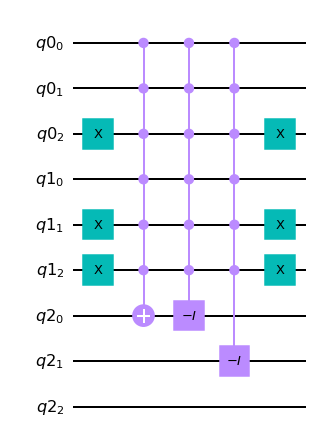

In [8]:
def rotation_2(n,i,j, m=2):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(m)
    rotation_2 = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'C_marked')
    
    i=bin(i)[2:]
    j=bin(j)[2:]
    #print(i,j)
    
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        rotation_2.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            rotation_2.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        rotation_2.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            rotation_2.x(q_r_1[len(j)-1-k])    
    
    rotation_2.mct(q_r_1[:]+q_r_2[:], q_c[0])
    
    #rotation_2.mct(q_r_1[:]+q_r_2[:], q_c[2])
    
    
    #rotation_2.h(q_c[:])
    neg = negative_gate().control(2*n)
    rotation_2.append(neg, q_r_1[:]+q_r_2[:] + [q_c[0]])
    rotation_2.append(neg, q_r_1[:]+q_r_2[:] + [q_c[1]])
    
    #rotation_2.append(negative_gate(), [q_c[2]])
    
  
    #print('i =', i)
    
    r = n-len(i)
    #print('r_i=',r)
    for k in range(r):
        rotation_2.x(q_r_2[n-1-k])
    for k in range(len(i)):
        if i[k]=='0':
            rotation_2.x(q_r_2[len(i)-1-k])
            
    #print('j =', j)
            
    r = n-len(j)
    #print('r_j=',r)
    for k in range(r):
        rotation_2.x(q_r_1[n-1-k])
    for k in range(len(j)):
        #print(k)
        if j[k]=='0':
            rotation_2.x(q_r_1[len(j)-1-k])  
  
    
    return rotation_2


rotation_2(3,1,3, 3).draw(output='mpl')

## Useful functions

In [9]:
def simulate(circuit, shots=1024):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts

In [10]:
def grover_dec_bar(n,counts):
    t= 2**(n)
    x= range(t)
    y= [0]*t
    for num in list(counts.keys()) :
        no = int(num, base = 2)
        y[no]+= counts[num]
    y = np.array(y)/sum(y)

    plt.bar(x,y)

In [11]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Walk on the NxN grid with self-loop

[1, 1, 1, 1, 0, 0, 0, 0]


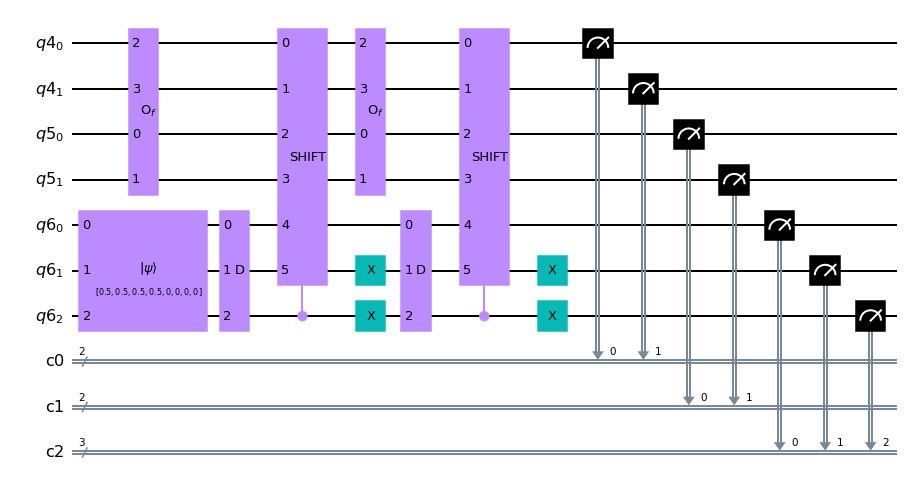

In [12]:
t = 2
n = 2
m=3
a=0
i,j = 0,0
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )


a_string = "1 "*(2**(m-1))
a_list = a_string.split()
map_object = map(int, a_list)
    
    
vector =  list(map_object)+[a]*(2**(m-1))
print(vector)
initial_state = vector/np.linalg.norm(vector)
    
circuit.initialize(initial_state, q_coin[:]) 

#circuit.x([q_coin[2]])

coin = diffuser(3)
oracle = grover_oracle(2*n, i+j*2**n)
shift = shift_gate(n).control(1)

for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(oracle, q_reg_j[:]+ q_reg_i[:])
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x( q_coin[1])
    circuit.x( q_coin[2])
    
#circuit.append(coin, q_coin[:])

circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

#circuit.measure(q_coin[:], c_coin[:])

circuit.draw(output ='mpl')

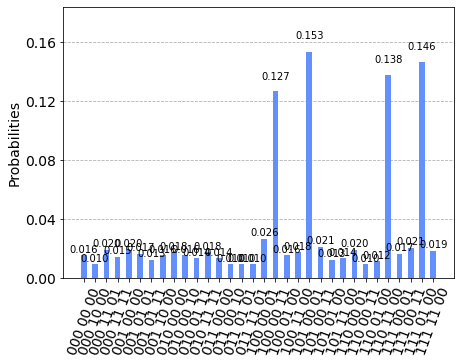

In [13]:
counts = simulate(circuit)
plot_histogram(counts)

[[ 68. 221.  26. 183.]
 [191.  27.   0.  27.]
 [ 26.   0.   0.   0.]
 [192.  30.   0.  33.]]


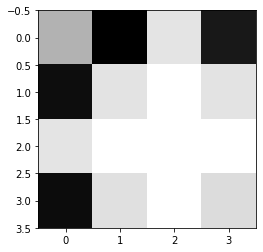

In [14]:
plt.imshow(show(n,counts,3)**(1.1), interpolation='nearest',vmin=0, vmax=1024/3, cmap='binary')

### Search walk on a N-N grid with self-loop

[1, 1, 1, 1, 0.3, 0.3, 0.3, 0.3]


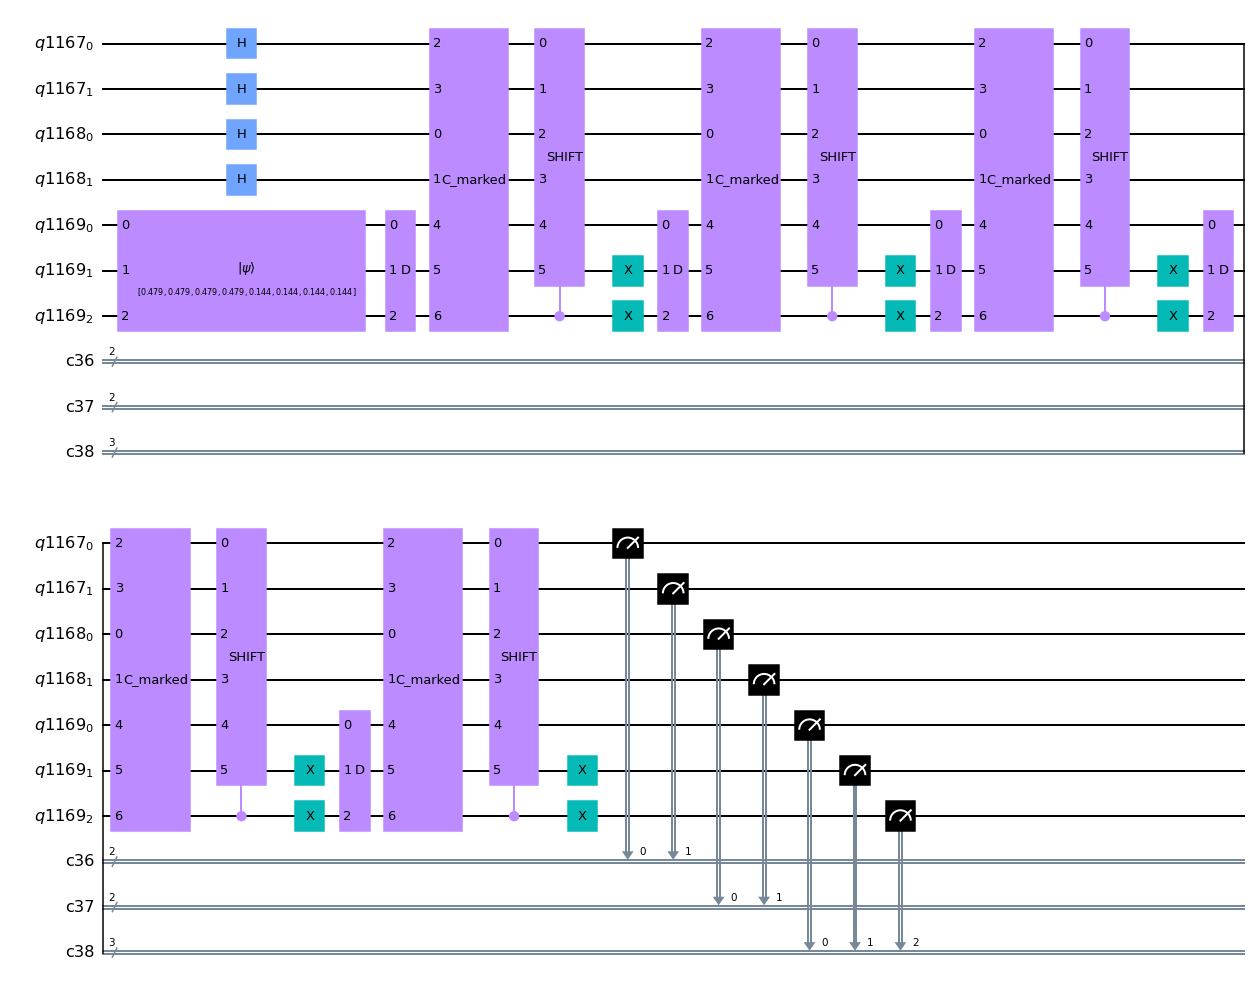

In [61]:
a=0.3
t = 5
n = 2
m=3
i,j = 2,3
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)

circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )



a_string = "1 "*(2**(m-1))
a_list = a_string.split()
map_object = map(int, a_list)
    
    
vector =  list(map_object)+[a]*(2**(m-1))
print(vector)
initial_state = vector/np.linalg.norm(vector)
    
circuit.initialize(initial_state, q_coin[:]) 

circuit.h(q_reg_j[:] + q_reg_i[:])

coin = diffuser(3)
rotation  = rotation_2(n,i,j,m)
shift = shift_gate(n).control(1)

for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(rotation, q_reg_j[:]+ q_reg_i[:]+q_coin[:])
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x( q_coin[1:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

#circuit.measure(q_coin[:], c_coin[:])
circuit.draw(output ='mpl')

[1, 1, 1, 1, 0.04, 0.04, 0.04, 0.04]


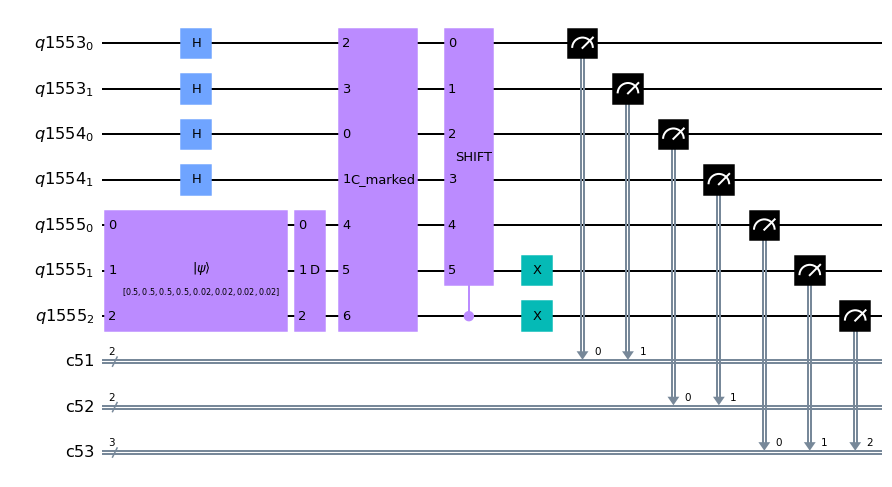

In [73]:
a=0.04
t = 1
n = 2
m=3
i,j = 2,3
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)

circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )



a_string = "1 "*(2**(m-1))
a_list = a_string.split()
map_object = map(int, a_list)
    
    
vector =  list(map_object)+[a]*(2**(m-1))
print(vector)
initial_state = vector/np.linalg.norm(vector)
    
circuit.initialize(initial_state, q_coin[:]) 

circuit.h(q_reg_j[:] + q_reg_i[:])

coin = diffuser(3)
rotation = rotation_2(n,i,j,m)
shift = shift_gate(n).control(1)

for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(rotation, q_reg_j[:]+ q_reg_i[:]+q_coin[:])
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x( q_coin[1:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

#circuit.measure(q_coin[:], c_coin[:])
circuit.draw(output ='mpl')


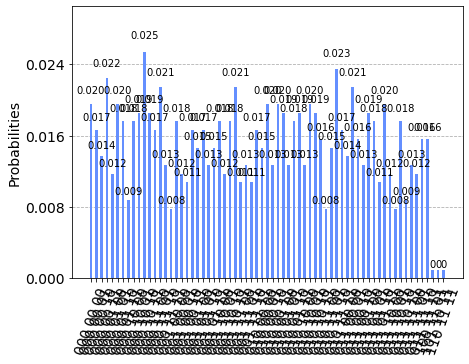

In [74]:
counts = simulate(circuit)
plot_histogram(counts)

[[67. 71. 54. 73.]
 [65. 68. 60. 63.]
 [61. 59. 81. 67.]
 [49. 63. 64. 59.]]


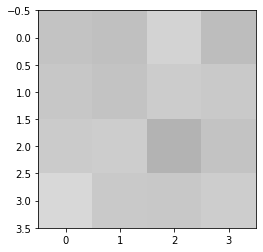

In [75]:
plt.imshow(show(n,counts,3)**(1.3), interpolation='nearest',vmin=0, vmax=1024, cmap='binary')

In [52]:
import pandas as pd

def search(filename,p, n,i,j,a,vm, v= False):
    Proba=[]

    for t in range(p): 


        q_reg_i = QuantumRegister(n)
        q_reg_j = QuantumRegister(n)
        q_coin = QuantumRegister(3)
        c_reg_i = ClassicalRegister(n)
        c_reg_j = ClassicalRegister(n)
        c_coin = ClassicalRegister(3)

        circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )



        a_string = "1 "*(2**(m-1))
        a_list = a_string.split()
        map_object = map(int, a_list)


        vector =  list(map_object)+[a]*(2**(m-1))
        print(vector)
        initial_state = vector/np.linalg.norm(vector)

        circuit.initialize(initial_state, q_coin[:]) 

        circuit.h(q_reg_j[:] + q_reg_i[:])

        coin = diffuser(3)
        rotation  = grover_oracle(2*n, i+j*2**n)
        shift = shift_gate(n).control(1)

        for _ in range(t) :
            circuit.append(coin, q_coin[:])
            circuit.append(rotation, q_reg_j[:]+ q_reg_i[:])
            circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
            circuit.x( q_coin[1:])


        circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

        counts = simulate(circuit)

        grid = show(n,counts,3)
        Proba+= [grid[j][i]]

        plt.imshow(((grid**1.1)*3/1024), interpolation='nearest',vmin=0, vmax=vm, cmap='binary') 
        plt.colorbar()


        plt.title("Grid, t="+str(t))
        plt.xlabel("index i")
        plt.ylabel("index j ")
        print('t = ',t)
        print('Proba = ',Proba)
        plt.savefig('image/'+filename+'_'+str(t)+'.png')
        plt.clf()
    pd.DataFrame(Proba).to_csv(filename+'.csv')
    return Proba

In [213]:
Proba_simple =  [13.0, 10.0, 21.0, 21.0, 37.0, 38.0, 63.0, 68.0, 64.0, 70.0, 88.0, 95.0, 93.0, 91.0, 78.0, 65.0, 41.0, 46.0]

In [220]:
filename ='loop_3'
p=20
n=2
a=0.1
i,j=1,2
vmax = 0.5
search(filename,p, n,i,j, a, vmax)

[1, 1, 1, 1, 0, 0, 0, 0]
[[75. 50. 76. 59.]
 [52. 61. 65. 72.]
 [60. 87. 62. 58.]
 [49. 65. 70. 63.]]
t =  0
Proba =  [87.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[65. 71. 62. 55.]
 [60. 56. 61. 69.]
 [71. 57. 71. 63.]
 [71. 52. 68. 72.]]
t =  1
Proba =  [87.0, 57.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[ 80.  54. 118.  52.]
 [ 27. 105.  11. 129.]
 [ 54.  38.  99.  46.]
 [ 57.  57.  33.  64.]]
t =  2
Proba =  [87.0, 57.0, 38.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[38. 60. 93. 66.]
 [64. 77. 60. 86.]
 [45. 57. 79. 66.]
 [78. 43. 66. 46.]]
t =  3
Proba =  [87.0, 57.0, 38.0, 57.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[ 39.  42.  84.  51.]
 [118.  82.  57.  82.]
 [ 38.  47.  98.  49.]
 [ 46.  31. 118.  42.]]
t =  4
Proba =  [87.0, 57.0, 38.0, 57.0, 47.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[ 58.  30. 120.  25.]
 [ 86. 124.  29. 121.]
 [ 43.  31. 107.  21.]
 [ 32.  61.  92.  44.]]
t =  5
Proba =  [87.0, 57.0, 38.0, 57.0, 47.0, 31.0]
[1, 1, 1, 1, 0, 0, 0, 0]
[[ 41.  47.  74.  57.]
 [138.  88.  20.  96.]
 [ 55.  52.  78.  41.]
 [ 10.  44. 153.  

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

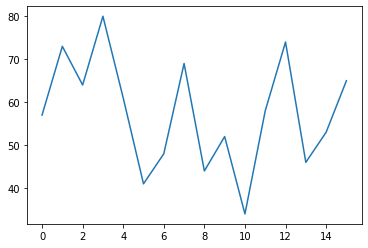

In [54]:
Proba =  [57.0, 73.0, 64.0, 80.0, 61.0, 41.0, 48.0, 69.0, 44.0, 52.0, 34.0, 58.0, 74.0, 46.0, 53.0, 65.0]
pd.DataFrame(Proba).to_csv('2D_search_with_loop.csv')
plt.plot(Proba)
#plt.plot(Proba_simple)

In [55]:
flip_flop_16 = pd.read_csv('2D_search_flip_flop_16.csv', sep=',')
loop_16 = pd.read_csv('2D_search_with_loop.csv', sep=',')

Text(0.5, 1.0, 'Effect of the loop')

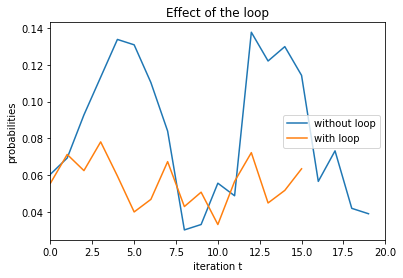

In [57]:

plt.plot(flip_flop_16['0']/1024, label = 'without loop')
plt.plot(loop_16['0']/1024,  label = 'with loop')
plt.xlim([0, 20])
plt.legend()
plt.xlabel('iteration t')
plt.ylabel('probabilities')
plt.title('Effect of the loop a = ')

### Conclusion

The 